In [1]:
from re import T
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from time import sleep
import os
from difflib import SequenceMatcher
import json
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import helpers
import api

In [2]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [3]:
df_MCQ = pd.read_csv('results/MCQ_sample_solved_2024_05_16_09_21_35.csv')
df_MCQ_EN = pd.read_csv('results/MCQ_sample_solved_EN_2024_05_16_09_21_35.csv')
df_PT = pd.read_csv('results/provas_enem_sample_solved_2024_05_16_09_21_35.csv').drop(columns=['CE','DS', 'EK', 'IC', 'MR', 'TC', 'image', 'IU', 'ledor', 'figures'])
df_EN = pd.read_csv('results/provas_enem_sample_solved_EN_2024_05_16_09_21_35.csv').drop(columns=['CE','DS', 'EK', 'IC', 'MR', 'TC', 'image', 'IU', 'ledor', 'figures'])

In [4]:
# Padronizar os valores dos níveis de dificuldade para inglês
df_MCQ['difficult_level'] = df_MCQ['difficult_level'].map({
    'Iniciante': 'Beginner',
    'Intermediário': 'Intermediate',
    'Avançado': 'Advanced'
})

# Padronizar os valores dos níveis de Bloom para inglês
df_MCQ['bloom_level'] = df_MCQ['bloom_level'].map({
    'Analisar': 'Analyze',
    'Análise': 'Analyze',
    'Aplicar': 'Apply',
    'Aplicação': 'Apply',
    'Avaliar': 'Evaluate',
    'Avaliação': 'Evaluate',
    'Compreender': 'Understand',
    'Compreensão': 'Understand',
    'Lembrar': 'Remember',
    'Recordar': 'Remember'
})

# Padronizar os valores dos níveis de dificuldade para inglês
df_MCQ_EN['difficult_level'] = df_MCQ['difficult_level'].map({
    'Iniciante': 'Beginner',
    'Intermediário': 'Intermediate',
    'Avançado': 'Advanced'
})

# Padronizar os valores dos níveis de Bloom para inglês
df_MCQ_EN['bloom_level'] = df_MCQ['bloom_level'].map({
    'Analisar': 'Analyze',
    'Análise': 'Analyze',
    'Aplicar': 'Apply',
    'Aplicação': 'Apply',
    'Avaliar': 'Evaluate',
    'Avaliação': 'Evaluate',
    'Compreender': 'Understand',
    'Compreensão': 'Understand',
    'Lembrar': 'Remember',
    'Recordar': 'Remember'
})

df_MCQ['correct_answer'] = df_MCQ['correct_answer'].apply(lambda x: x.replace("'", ""))
df_MCQ_EN['correct_answer'] = df_MCQ_EN['correct_answer'].apply(lambda x: x.replace("'", ""))
df_PT['correct_answer'] = df_PT['correct_answer'].apply(lambda x: x.replace("'", ""))
df_EN['correct_answer'] = df_EN['correct_answer'].apply(lambda x: x.replace("'", ""))
df_PT['correct_answer'] = df_PT['correct_answer'].str.strip()
df_EN['correct_answer'] = df_EN['correct_answer'].str.strip()

In [5]:
res = pd.DataFrame(columns=['df_name', 'area', 'year', 'ratio', 'correct'])
def count_matches(correct_answers, system_answers, area, year, df_name, threshold=0.9):
    match_count = 0
    not_match_count = 0

    for i in range(len(correct_answers)):
        correct_answer = re.sub(r'\s+', '', str(correct_answers[i]).strip())
        system_answer = re.sub(r'\s+', '', str(system_answers[i]).strip())
        
        ratio = similar(correct_answer, system_answer)
        
        if ratio >= threshold:
            correct = 'yes'
            match_count += 1
        else:
            correct = 'no'
            not_match_count += 1
        
        res.loc[len(res)] = {'area': area[i], 'year': year[i], 'ratio': ratio, 'correct': correct, 'df_name': df_name}
    return match_count, not_match_count


data = {
    'df_MCQ': df_MCQ,
    'df_MCQ_EN': df_MCQ_EN,
    'df_PT': df_PT,
    'df_EN': df_EN
}


for df_name, df in data.items():
    equal_count, not_equal_count = count_matches(df['correct_answer'], df['system_answer'], df['area'], df['year'], df_name)
    print(f"DF: {df_name}:")
    print(f"TOTAL: {len(df['correct_answer'])}:")
    print("EQUALS:", equal_count)
    print("DISTINCT:", not_equal_count)
    print()



DF: df_MCQ:
TOTAL: 850:
EQUALS: 667
DISTINCT: 183

DF: df_MCQ_EN:
TOTAL: 839:
EQUALS: 693
DISTINCT: 146

DF: df_PT:
TOTAL: 241:
EQUALS: 150
DISTINCT: 91

DF: df_EN:
TOTAL: 221:
EQUALS: 152
DISTINCT: 69



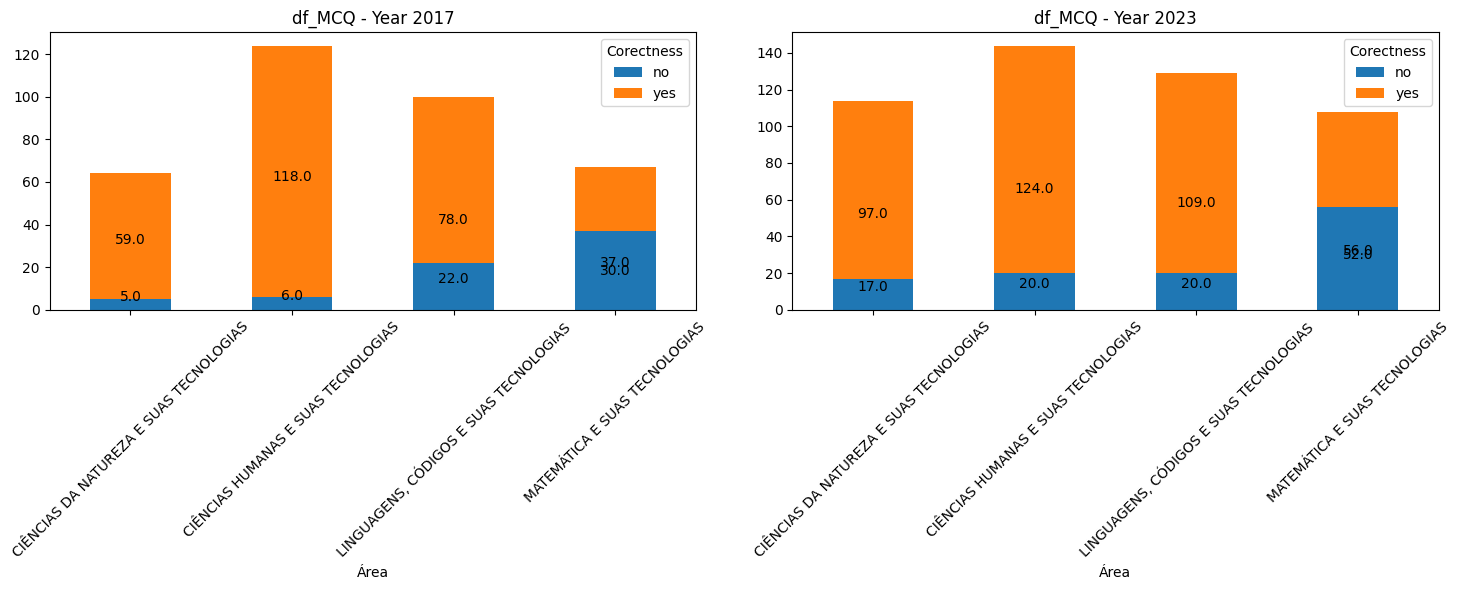

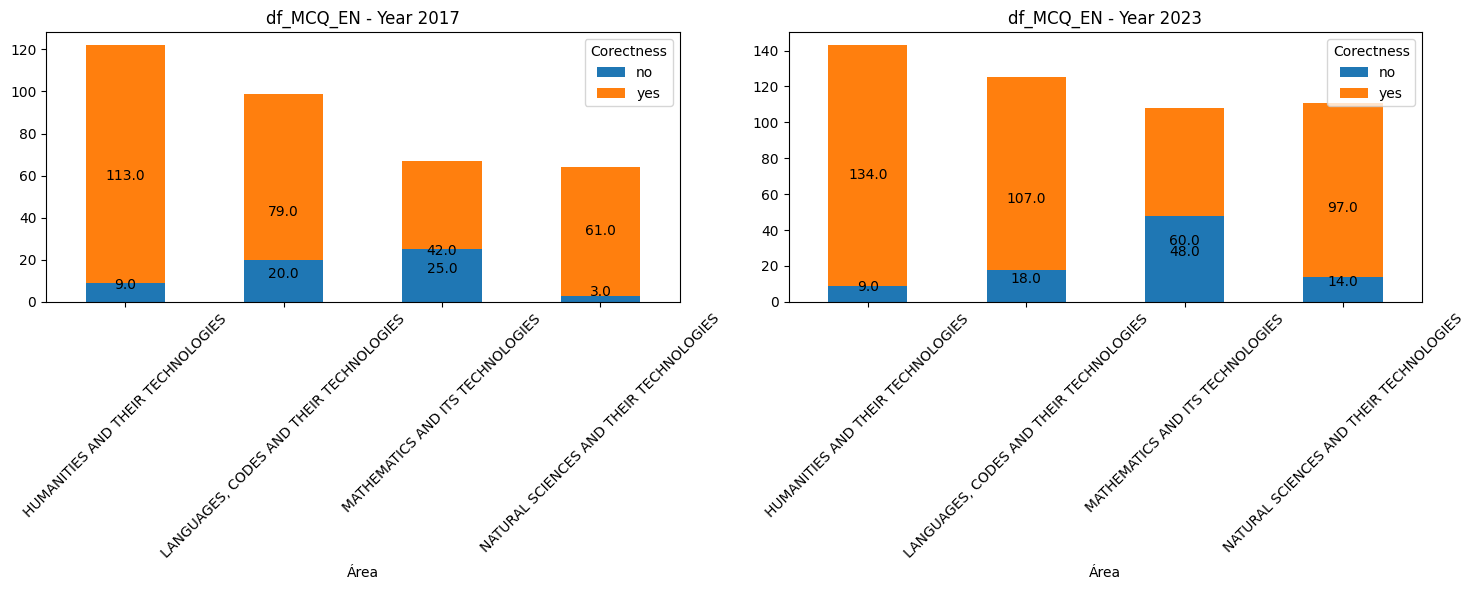

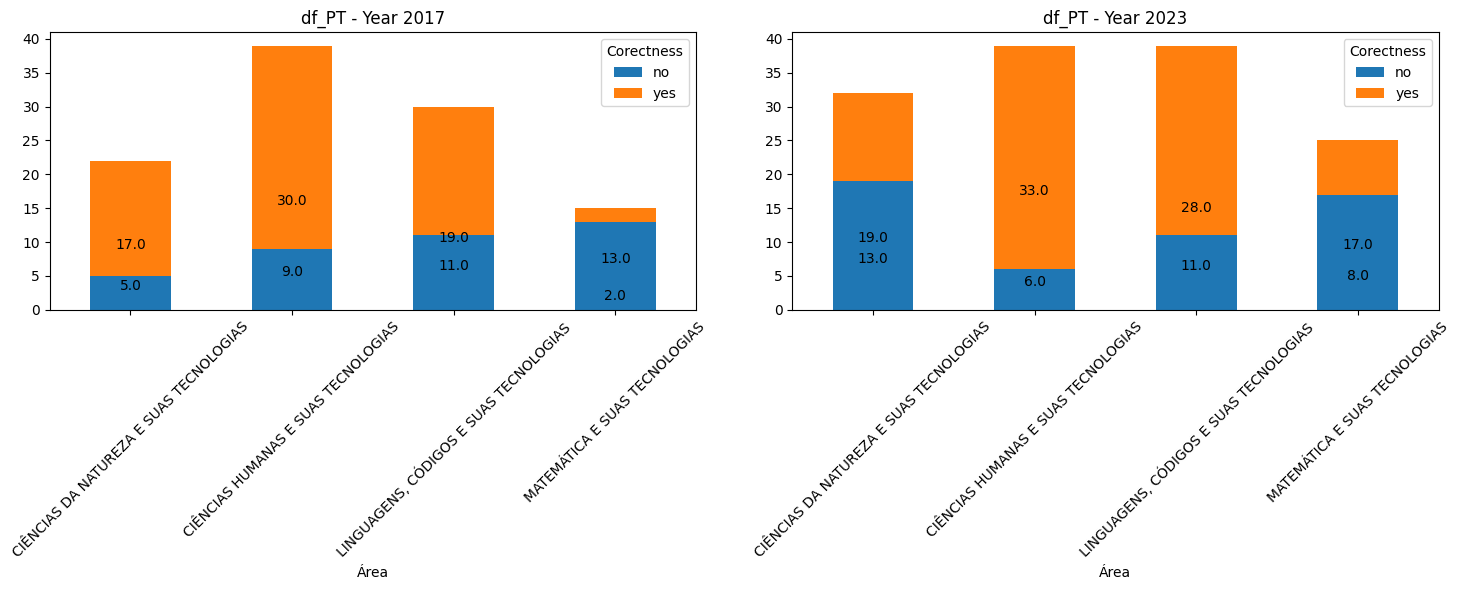

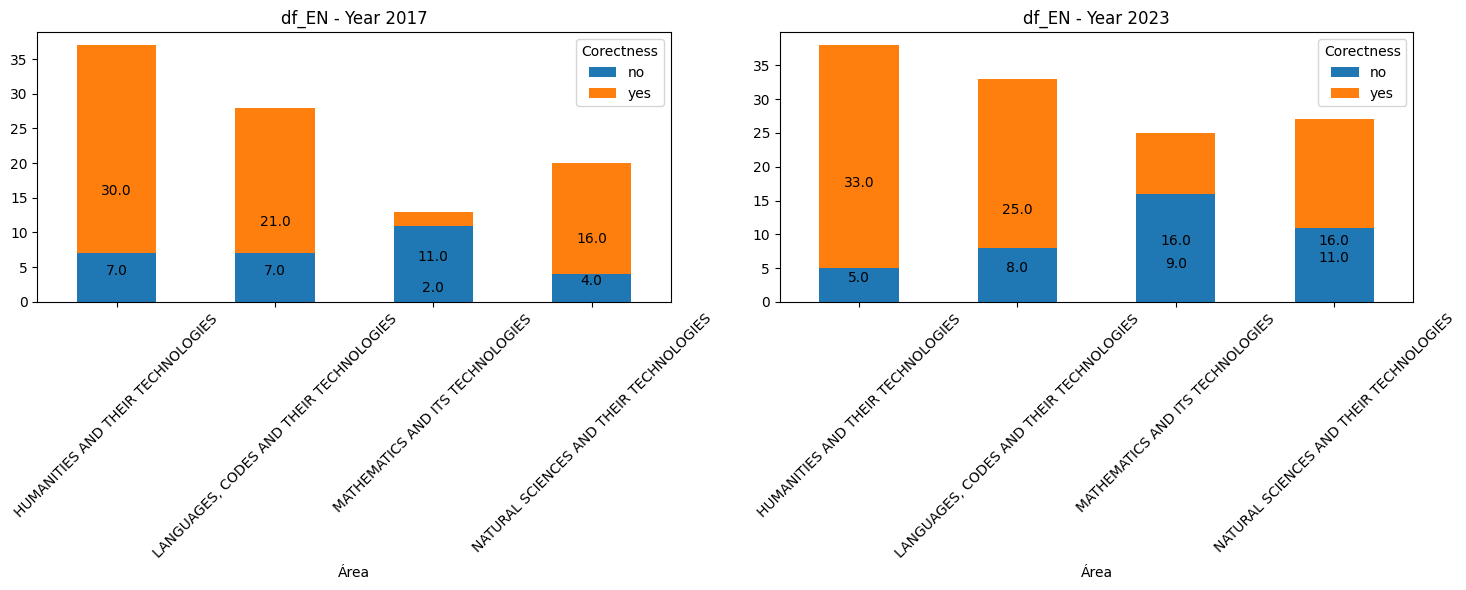

In [6]:
grouped = res.groupby(['df_name', 'year', 'area', 'correct']).size().unstack(fill_value=0)

df_names = res['df_name'].unique()

for df_name in df_names:
    df_subset = grouped.loc[df_name]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(df_subset.index.levels[0]), figsize=(15, 6))
    
    for i, year in enumerate(df_subset.index.levels[0]):
        ax = axes[i]
        year_data = df_subset.loc[year]
        year_data.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'{df_name} - Year {year}')
        ax.set_xlabel('Área')
        ax.legend(title='Corectness')
        ax.set_xticklabels(year_data.index, rotation=45)
        
        for bar in ax.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [7]:
merged_df = pd.merge(df_PT, df_EN, on='id', suffixes=('_pt', '_en'))

common_system_answers = merged_df[merged_df['system_answer_pt'].str[1] == merged_df['system_answer_en'].str[1]]
unique_system_answers = merged_df[merged_df['system_answer_pt'].str[1] != merged_df['system_answer_en'].str[1]]

num_common_ids = len(common_system_answers)
num_unique_ids = len(unique_system_answers)

print("MATCH:", num_common_ids)
print("NOT MATCH:", num_unique_ids)

MATCH: 199
NOT MATCH: 180


In [8]:
res_2 = pd.DataFrame(columns=['area', 'year', 'ratio', 'correct', 'df_name'])
def count_matches(correct_answers, system_answers, area, year, threshold=0.9):
    match_count = 0
    not_match_count = 0

    for i in range(len(correct_answers)):
        correct_answer = str(correct_answers[i])[1]
        system_answer = str(system_answers[i])[1]
        
        ratio = similar(correct_answer, system_answer)
        
        if ratio >= threshold:
            correct = 'yes'
            match_count += 1
        else:
            correct = 'no'
            not_match_count += 1
        
        res_2.loc[len(res_2)] = {'area': area[i], 'year': year[i], 'ratio': ratio, 'correct': correct, 'df_name': 'merged'}
    return match_count, not_match_count

merged_df = pd.merge(df_PT, df_EN, on='id', suffixes=('_pt', '_en'))


equal_count, not_equal_count = count_matches(merged_df['system_answer_pt'], merged_df['system_answer_en'], merged_df['area_pt'], merged_df['year_pt'])
print(f"TOTAL: {len(merged_df['system_answer_pt'])}:")
print("EQUALS:", equal_count)
print("DISTINCT:", not_equal_count)
print()



TOTAL: 379:
EQUALS: 199
DISTINCT: 180



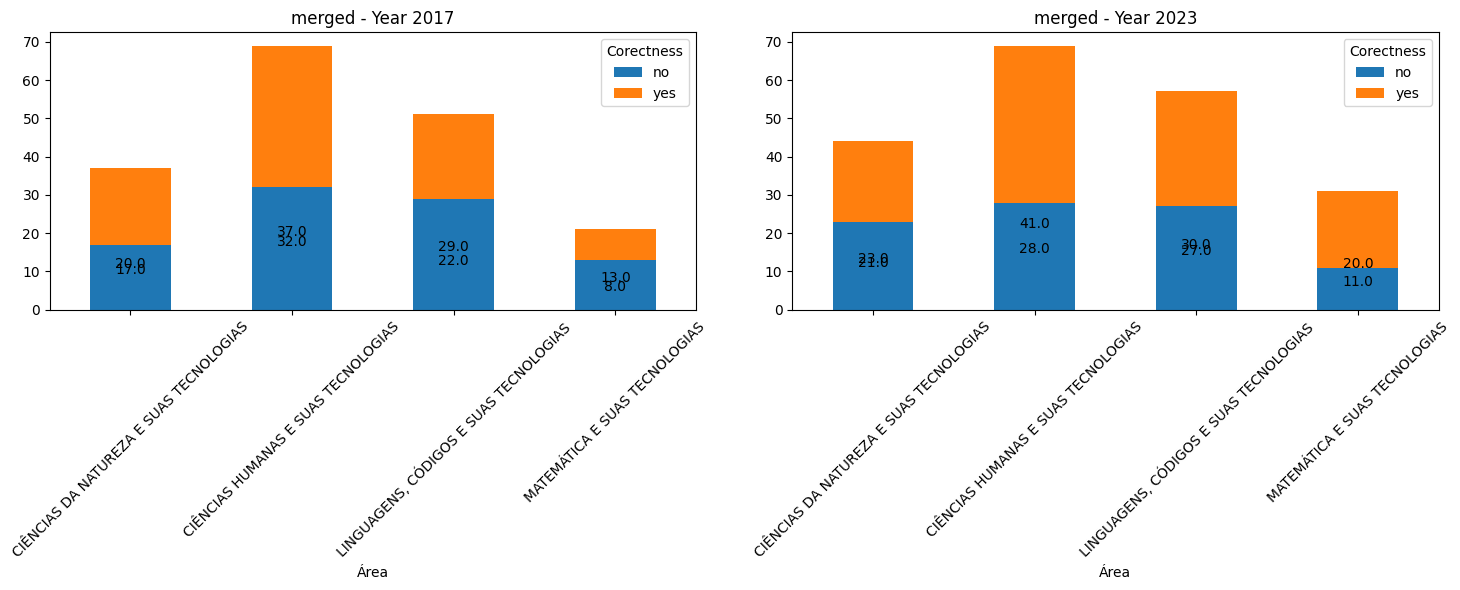

In [9]:
grouped = res_2.groupby(['df_name', 'year', 'area', 'correct']).size().unstack(fill_value=0)

df_names = res_2['df_name'].unique()

for df_name in df_names:
    df_subset = grouped.loc[df_name]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(df_subset.index.levels[0]), figsize=(15, 6))
    
    for i, year in enumerate(df_subset.index.levels[0]):
        ax = axes[i]
        year_data = df_subset.loc[year]
        year_data.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'{df_name} - Year {year}')
        ax.set_xlabel('Área')
        ax.legend(title='Corectness')
        ax.set_xticklabels(year_data.index, rotation=45)
        
        for bar in ax.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [10]:
df_MCQ_EN.columns

Index(['area', 'year', 'context', 'question', 'options', 'correct_answer',
       'bloom_level', 'difficult_level', 'relevance', 'adherence',
       'answerability', 'correctness', 'feedback', 'rouge', 'bleu',
       'system_answer', 'steps_answer', 'model'],
      dtype='object')

In [11]:
df_MCQ_EN_copy = df_MCQ_EN.drop(columns=['context', 'question', 'options', 'correct_answer',
       'bloom_level', 'difficult_level', 'feedback', 'rouge', 'bleu',
       'system_answer', 'steps_answer', 'model']).copy()
df_MCQ_EN_copy['df_name'] = 'df_MCQ_EN'
df_MCQ_copy = df_MCQ_EN.drop(columns=['context', 'question', 'options', 'correct_answer',
       'bloom_level', 'difficult_level', 'feedback', 'rouge', 'bleu',
       'system_answer', 'steps_answer', 'model']).copy()
df_MCQ_copy['df_name'] = 'df_MCQ'

In [12]:
df_MCQ_copy

,area,year,relevance,adherence,answerability,correctness,df_name
0,NATURAL SCIENCES AND THEIR TECHNOLOGIES,2017,5,4,5,1,df_MCQ
1,NATURAL SCIENCES AND THEIR TECHNOLOGIES,2017,5,4,5,1,df_MCQ
2,NATURAL SCIENCES AND THEIR TECHNOLOGIES,2017,5,4,5,1,df_MCQ
3,NATURAL SCIENCES AND THEIR TECHNOLOGIES,2017,5,4,5,1,df_MCQ
4,NATURAL SCIENCES AND THEIR TECHNOLOGIES,2017,5,4,5,0,df_MCQ
...,...,...,...,...,...,...,...
834,MATHEMATICS AND ITS TECHNOLOGIES,2023,5,4,5,1,df_MCQ
835,MATHEMATICS AND ITS TECHNOLOGIES,2023,5,4,5,1,df_MCQ
836,MATHEMATICS AND ITS TECHNOLOGIES,2023,5,4,5,1,df_MCQ
837,MATHEMATICS AND ITS TECHNOLOGIES,2023,5,4,5,1,df_MCQ


In [13]:
relevance_summary = df_MCQ['relevance'].value_counts().sort_index()
print("Relevance Summary: ", relevance_summary)
adherence_summary = df_MCQ['adherence'].value_counts().sort_index()
print("Adherence Summary: ", adherence_summary)
answerability_summary = df_MCQ['answerability'].value_counts().sort_index()
print("Answerability Summary: ", answerability_summary)
correctness_summary = df_MCQ['correctness'].value_counts().sort_index()
print("Correctness Summary: ", correctness_summary)

Relevance Summary:  relevance
2.0      8
3.0      8
4.0    136
4.5      3
5.0    695
Name: count, dtype: int64
Adherence Summary:  adherence
1      3
2      7
3    126
4    485
5    229
Name: count, dtype: int64
Answerability Summary:  answerability
1      3
2      3
3      9
4     99
5    736
Name: count, dtype: int64
Correctness Summary:  correctness
no      71
yes    779
Name: count, dtype: int64


In [14]:
relevance_summary = df_MCQ_EN['relevance'].value_counts().sort_index()
print("Relevance Summary: ", relevance_summary)
adherence_summary = df_MCQ_EN['adherence'].value_counts().sort_index()
print("Adherence Summary: ", adherence_summary)
answerability_summary = df_MCQ_EN['answerability'].value_counts().sort_index()
print("Answerability Summary: ", answerability_summary)
correctness_summary = df_MCQ_EN['correctness'].value_counts().sort_index()
print("Correctness Summary: ", correctness_summary)

Relevance Summary:  relevance
1      1
2      1
3      2
5    835
Name: count, dtype: int64
Adherence Summary:  adherence
2      2
3     36
4    775
5     26
Name: count, dtype: int64
Answerability Summary:  answerability
4     23
5    816
Name: count, dtype: int64
Correctness Summary:  correctness
0    217
1    622
Name: count, dtype: int64
